#### Energy Model and partial "report"
---
Use some publicly available production data to play around with creating a PVlib energy model, compare it to actual production, and do a basic report like one might use for a utility PV site.<br>



Site info from http://dkasolarcentre.com.au/source/alice-springs/dka-m5-b-phase<br><br>
Note that the data now does not report met station data (only power, PR, and some others) and so we will use this older data file from 2018 to do our work.
<br><br>
Array Rating	5.1kW<br>
Panel Rating	170W<br>
Number Of Panels	30<br>
Panel Type	BP 4170N<br>
Array Area	37.8 m²<br>
Type Of Tracker	N/A<br>
Inverter Size / Type	6 kW, SMA SMC 6000A<br>
Installation Completed	Tue, 11 Nov 2008<br>
Array Tilt/Azimuth	Tilt = 20, Azi = 0 <br>
<br>
Hardware info:<br>
http://www.solardesigntool.com/components/inverter-grid-tie-solar/SMA/387/SMC-6000A/specification-data-sheet.html<br>
http://www.posharp.com/bp4170n-solar-panel-from-bp-solar_p1153991998d.aspx
<br><br>
So let's get to building a model. The python script "ImportData" does the dirty work of formatting, calculating POAs and Tcell from met station, etc.

In [1]:
import pandas as pd
import pvlib
import matplotlib.pyplot as plt
%matplotlib inline

from ImportData import df # previously imported and calculated data

In [2]:
# Define some of the site info and hardware

module = pvlib.pvsystem.retrieve_sam('SandiaMod')['BP_Solar_BP4170__2003__E__']
inverter = pvlib.pvsystem.retrieve_sam('cecinverter')['SMA_America__SB6000TL_US__240V_']
# not sure if right inverter, exact "SMC" model not listed

meta = {"latitude": -23.762028,
        "longitude": 133.874886,
        "timezone": 'Australia/North',
        "tempco": -0.005,
        "azimuth": 0,
        "tilt": 20,
        "pdc": 5100.0,
        "temp_model": 'open_rack_cell_polymerback',
        "a":-3.56,
        "b":-0.075,
        'delT':3} # a b delT for open rack glass/polymer module model

t_model_params = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']["open_rack_glass_polymer"]  # Also can do like this

In [3]:
# Attempt model chain  

# Dont have info on layout of site, so I'm guessing (based on voltages) 3 strings of 10 panels
system = pvlib.pvsystem.PVSystem(surface_tilt = 20, 
                                 surface_azimuth=0, 
                                 module_parameters=module, 
                                 modules_per_string=10, 
                                 strings_per_inverter=3, 
                                 inverter_parameters=inverter, 
                                 racking_model='open_rack',
                                 temperature_model_parameters=t_model_params)

location = pvlib.location.Location(meta['latitude'],meta['longitude'],name='BP',tz=meta['timezone'])

mc = pvlib.modelchain.ModelChain(system, 
                                 location,
                                 losses_model='pvwatts')
# https://pvlib-python.readthedocs.io/en/stable/generated/pvlib.pvsystem.pvwatts_losses.html
# Using default values
# Default includes a 1% nameplate loss, I believe this lines up with the 1.1%/yr degradation we fit in DegradationAnalysis

weather = df[['dni','ghi','dhi','Tcell']].rename(columns = {'Tcell':'cell_temperature'}) # Necessary layout for ModelChain

mc.run_model(weather)
df['ac'] = mc.ac # Model ac power
df['expected'] = df.ac * pd.to_timedelta(df.ac.index.freq).total_seconds()/(3600) # Expected Energy (model from real weather)

#### Model vs. Actual
Given the pvlib model we've created, we can check how good it is by scattering the actual power vs. the modeled power. Ideally this would all be along the x=y line (red).<br><br>
We are fairly close!<br>
Before we added the losses model, the model was over-predicting power.<br>
<b>BUT</b> the uncertainty for any single point is pretty wide - like 500W. We can also see some strange line patterns that I would expect to be when the site may have had performance issues (failures, shading, soiling etc.). Times when modeled power is ~0 are probably where met station data is incorrect or has comms issues.

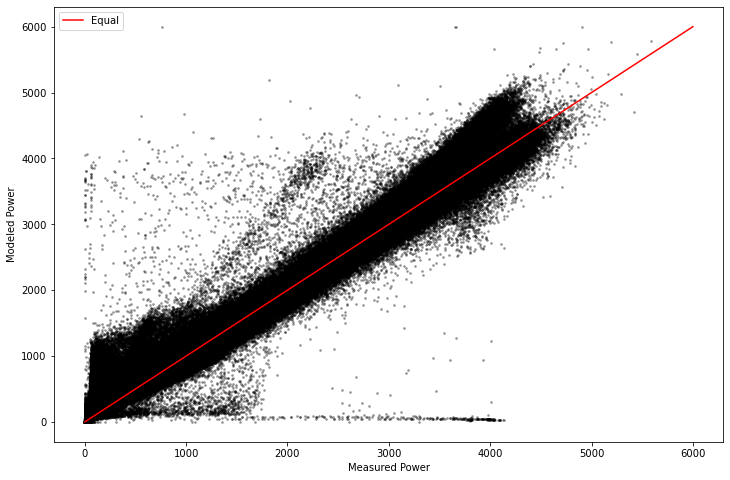

In [4]:
plt.figure(figsize=(12,8))
plt.scatter(df.power, mc.ac, alpha=0.3, s=3, c='k')
plt.plot([0,6000],[0,6000],c='r',label='Equal')
plt.xlabel('Measured Power')
plt.ylabel('Modeled Power')
plt.legend()

### Fake Report

Let's do some plots and analysis like we would for a solar plant. One would want to know what was produced vs. what we should have produced.<br>
We'll look at the available resource (insolation = irradiance * time), the actual production, the expected production, and the predicted production.<br><br>
<i>
Predicted = Month/year before, using the TMY data to predict what we would see<br>
Expected = Given actual solar resource, what does the model say was produced?<br>
Measured = What does our utility meter say we produced?
</i>
<br><Br>
#### Insolation vs. Energy
Looking at plant production vs. available insolation can tell us if we've missed production, had downtime, etc.<br><br>
It looks here like we probably didn't have inverter/site downtime.<br>
The POA sensor reads near 0 for a couple of days, but production is not much affected, so this looks like a met station issue for 2 days of the month

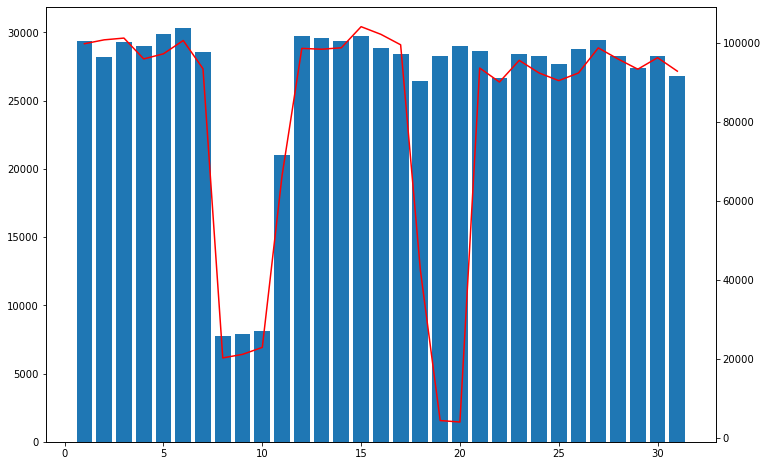

In [5]:
month = df['2018-03-01':'2018-03-31']
daily = month.resample('D')
# Insolation vs energy
fig, ax = plt.subplots(figsize=(12,8))
ax.bar(daily.energy.sum().index.day, daily.energy.sum(),label='Daily Energy')
ax2 = ax.twinx()
ax2.plot(daily.poa.sum().index.day, daily.poa.sum(), label='Daily Insolation', c='r')

#### Loss Waterfall

Compare the measured, expected, losses, and delta between that.<br><br>
Because we have no downtime events recorded, the "losses" is empty. If inverter/site downtime or curtailments were identified in the data we would model what energy we expect to have lost there.<br><br>
Here the delta is simply the difference between the expected and the measured. And for an old site in the desert, ~3% error seems pretty good. We could look at the trend over many months and see if we always predicted above/below actual (and note that we already said degradation might not be properly included here).

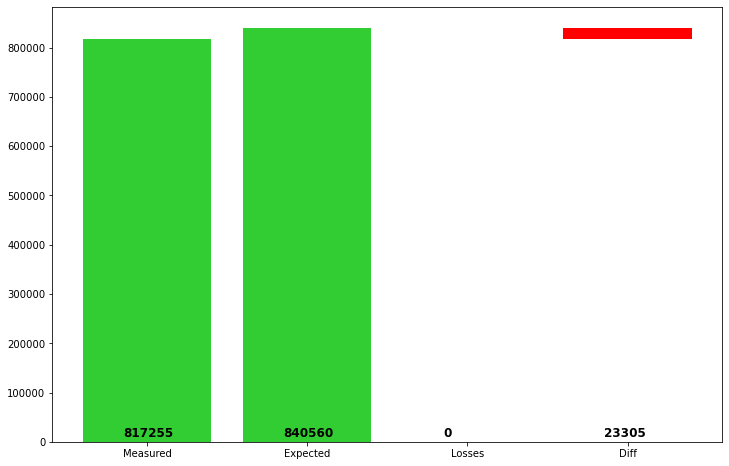

In [6]:
plt.figure(figsize=(12,8))
waterfall_cats = ['Measured','Expected','Losses','Diff']
waterfall_data = [month.energy.sum(), month.expected.sum(),0, month.expected.sum()-month.energy.sum()]
bots = [0,0,month.energy.sum(),month.energy.sum()]

plt.bar(waterfall_cats, 
        waterfall_data,
        bottom=bots,
        color=['limegreen','limegreen','r','r'])

for i,v in enumerate(waterfall_data):
    plt.text(i-0.15,10000,'{0:g}'.format(float(v)),size='large',weight='bold')


#### Further
If this was a real report we'd be showing outages, work orders, spare parts, time records, etc. as well here. If our site had trackers (this is fixed tilt) we might explore availability of those. We would record preventative maintenance.